# Imports

In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [3]:
import skimage.io
import seaborn as sn
import tensorflow as tf

In [4]:
import tensorflow.python.keras.backend as K

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Treinamento e teste 

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

# valid_datagen = ImageDataGenerator(rescale = 1./255,
#                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [7]:
train_dataset  = train_datagen.flow_from_directory(directory = 'train',
                                                   target_size = (48,48),
                                                   color_mode = "rgb",
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64,
                                                   shuffle=True)

Found 22968 images belonging to 7 classes.


In [8]:
result = next(train_dataset)

In [9]:
result[0].shape

(64, 48, 48, 3)

In [10]:
teste_y = train_dataset.classes

In [11]:
###### valid_datagen OU train_datagen????
valid_dataset = train_datagen.flow_from_directory(directory = 'train',
                                                  target_size = (48,48),
                                                  color_mode = "rgb",
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64,
                                                  shuffle=True)

Found 5741 images belonging to 7 classes.


In [12]:
test_dataset = test_datagen.flow_from_directory(directory = 'test',
                                                  target_size = (48,48),
                                                  color_mode = "rgb",
                                                  class_mode = 'categorical',
                                                  batch_size = 64,
                                                  shuffle=True)

Found 7178 images belonging to 7 classes.


# Construção Modelo

In [13]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [14]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [15]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

In [17]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png') 

In [18]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [20]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [21]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

# Fit do modelo 

In [22]:
from keras.callbacks import CSVLogger

In [28]:
epochs = 60
batch_size = 64
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = epochs,verbose = 1,callbacks=[lrd,mcp,es])


Epoch 1/60
359/359 [==============================] - 384s 1s/step - loss: 1.7597 - accuracy: 0.8570 - precision: 0.4732 - recall: 0.0065 - auc: 0.6848 - f1_score: 0.0128 - val_loss: 1.7276 - val_accuracy: 0.8573 - val_precision: 0.8889 - val_recall: 0.0014 - val_auc: 0.7065 - val_f1_score: 0.0027
Epoch 2/60
359/359 [==============================] - 391s 1s/step - loss: 1.7573 - accuracy: 0.8570 - precision: 0.4573 - recall: 0.0058 - auc: 0.6863 - f1_score: 0.0114 - val_loss: 1.7250 - val_accuracy: 0.8573 - val_precision: 0.7000 - val_recall: 0.0024 - val_auc: 0.7067 - val_f1_score: 0.0048
Epoch 3/60
359/359 [==============================] - 391s 1s/step - loss: 1.7496 - accuracy: 0.8571 - precision: 0.4813 - recall: 0.0078 - auc: 0.6909 - f1_score: 0.0153 - val_loss: 1.7219 - val_accuracy: 0.8573 - val_precision: 0.7273 - val_recall: 0.0014 - val_auc: 0.7080 - val_f1_score: 0.0027
Epoch 4/60
359/359 [==============================] - 392s 1s/step - loss: 1.7454 - accuracy: 0.8572 - 

359/359 [==============================] - 391s 1s/step - loss: 1.7222 - accuracy: 0.8575 - precision: 0.5496 - recall: 0.0138 - auc: 0.7070 - f1_score: 0.0266 - val_loss: 1.6810 - val_accuracy: 0.8576 - val_precision: 0.7568 - val_recall: 0.0049 - val_auc: 0.7307 - val_f1_score: 0.0095
Epoch 29/60
359/359 [==============================] - 390s 1s/step - loss: 1.7239 - accuracy: 0.8575 - precision: 0.5532 - recall: 0.0147 - auc: 0.7059 - f1_score: 0.0284 - val_loss: 1.6936 - val_accuracy: 0.8575 - val_precision: 0.7586 - val_recall: 0.0038 - val_auc: 0.7242 - val_f1_score: 0.0075
Epoch 30/60
359/359 [==============================] - 390s 1s/step - loss: 1.7212 - accuracy: 0.8573 - precision: 0.5192 - recall: 0.0141 - auc: 0.7083 - f1_score: 0.0272 - val_loss: 1.6904 - val_accuracy: 0.8574 - val_precision: 0.8000 - val_recall: 0.0028 - val_auc: 0.7247 - val_f1_score: 0.0056
Epoch 31/60
359/359 [==============================] - 391s 1s/step - loss: 1.7218 - accuracy: 0.8576 - precisio

359/359 [==============================] - 389s 1s/step - loss: 1.7112 - accuracy: 0.8576 - precision: 0.5469 - recall: 0.0168 - auc: 0.7130 - f1_score: 0.0323 - val_loss: 1.6784 - val_accuracy: 0.8576 - val_precision: 0.8148 - val_recall: 0.0038 - val_auc: 0.7322 - val_f1_score: 0.0075
Epoch 56/60
359/359 [==============================] - 387s 1s/step - loss: 1.7142 - accuracy: 0.8576 - precision: 0.5447 - recall: 0.0196 - auc: 0.7121 - f1_score: 0.0375 - val_loss: 1.6861 - val_accuracy: 0.8574 - val_precision: 0.6552 - val_recall: 0.0033 - val_auc: 0.7271 - val_f1_score: 0.0065
Epoch 57/60
359/359 [==============================] - 388s 1s/step - loss: 1.7182 - accuracy: 0.8577 - precision: 0.5585 - recall: 0.0185 - auc: 0.7085 - f1_score: 0.0355 - val_loss: 1.6872 - val_accuracy: 0.8573 - val_precision: 0.7059 - val_recall: 0.0021 - val_auc: 0.7290 - val_f1_score: 0.0041

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 00057: early stopping


## Salvando o history em json

In [29]:
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history_VGG16.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)


## Salvando o modelo

In [30]:
model.save("modelo_VGG16")

INFO:tensorflow:Assets written to: modelo_VGG16/assets


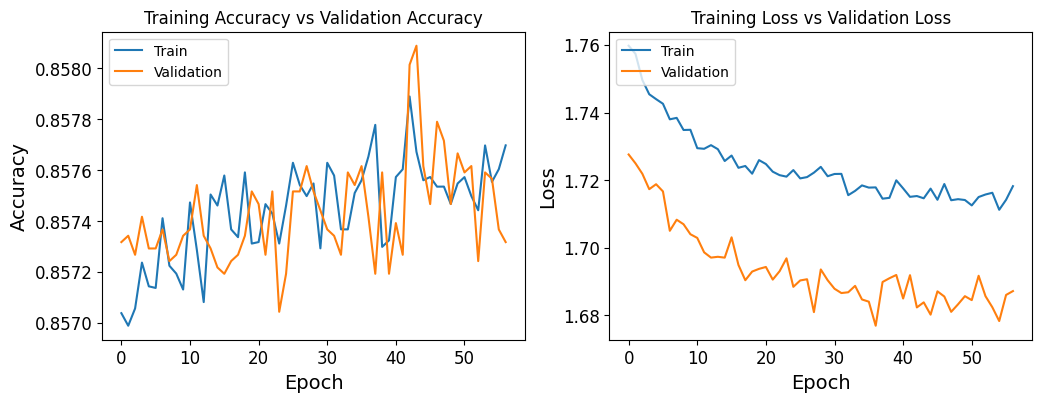

In [31]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
train_l = history.history['val_accuracy']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Evaluate 

In [32]:
results = model.evaluate(test_dataset, batch_size=64)

113/113 [==============================] - 95s 839ms/step - loss: 1.6557 - accuracy: 0.8573 - precision: 0.6053 - recall: 0.0032 - auc: 0.7439 - f1_score: 0.0063
